In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/var/folders/cl/wqxhc67j255bdr0rmv_bl3580000gn/T/ipykernel_56312/2332652948.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_combined['average'] = df_combined.mean(axis=1)


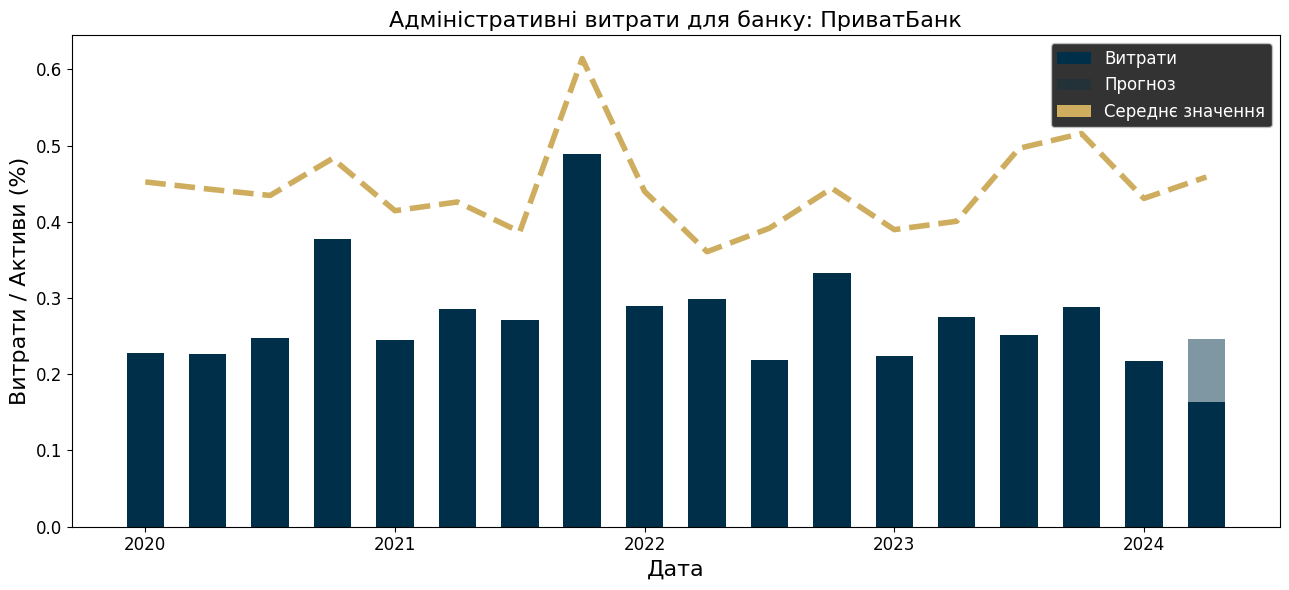

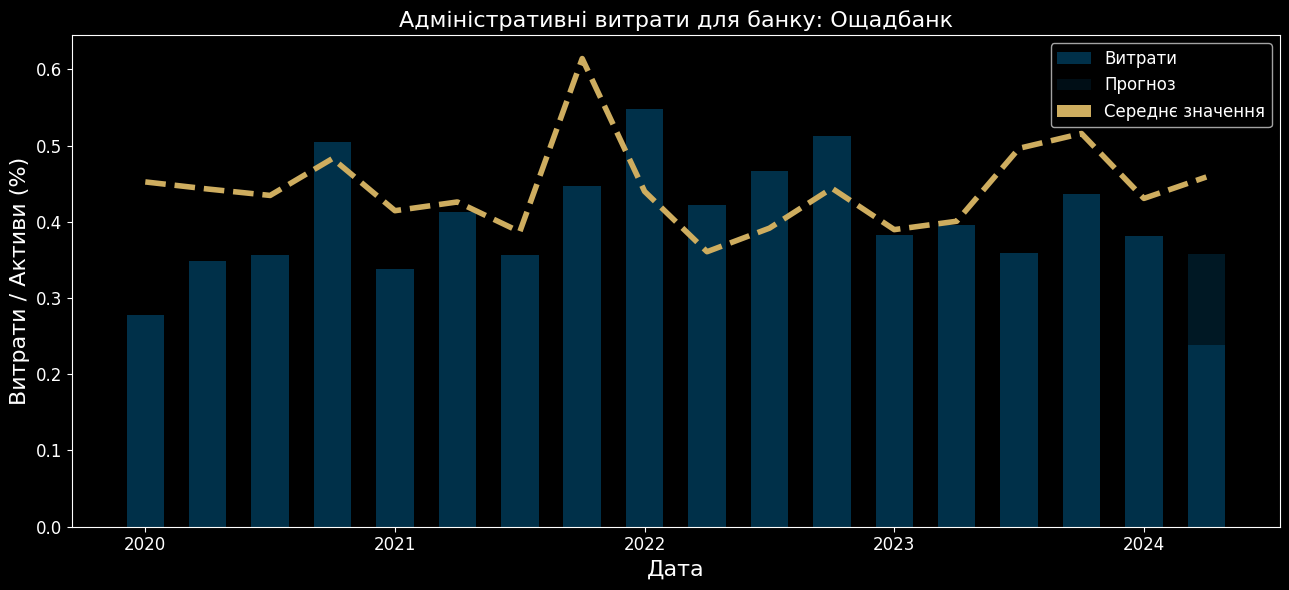

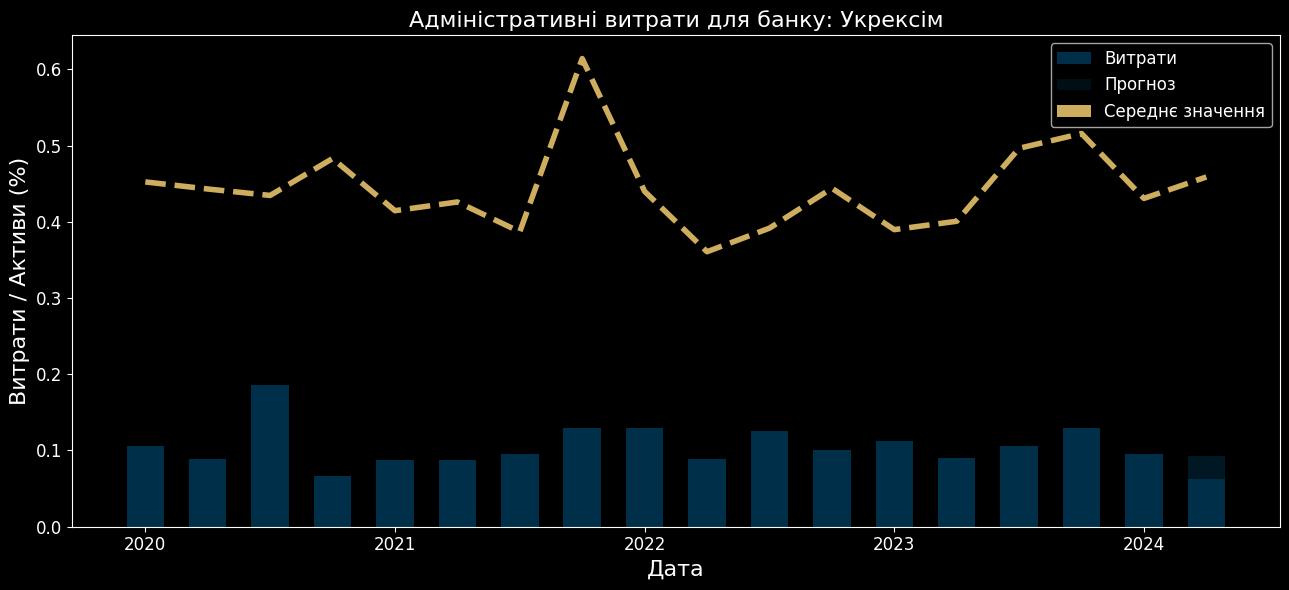

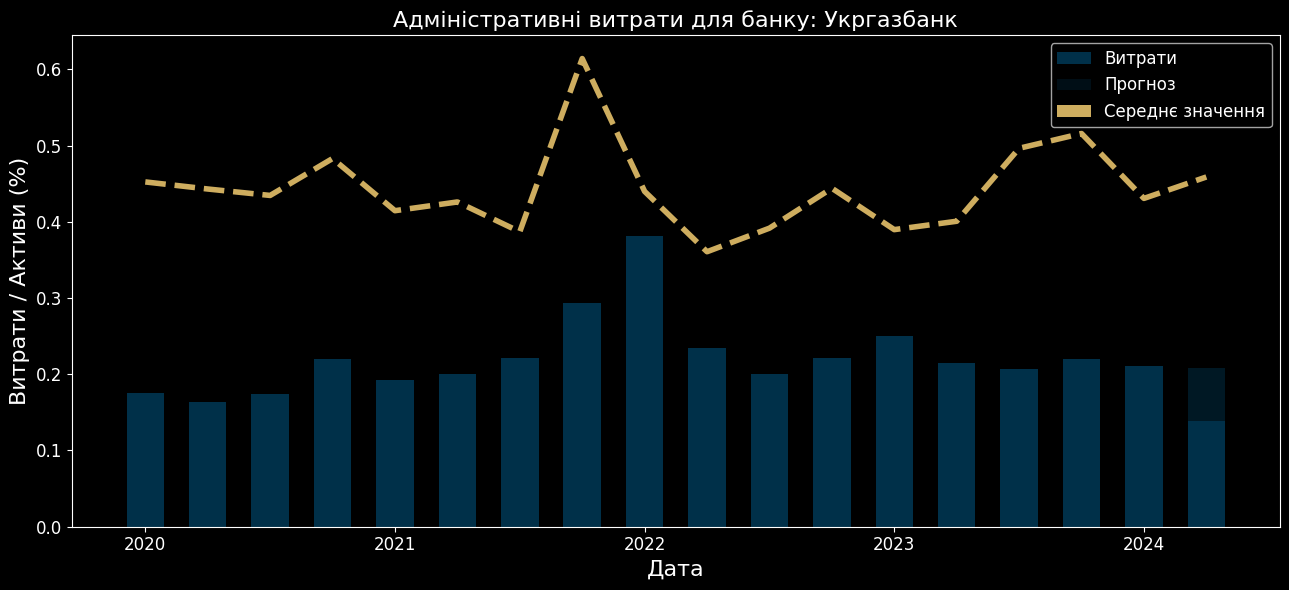

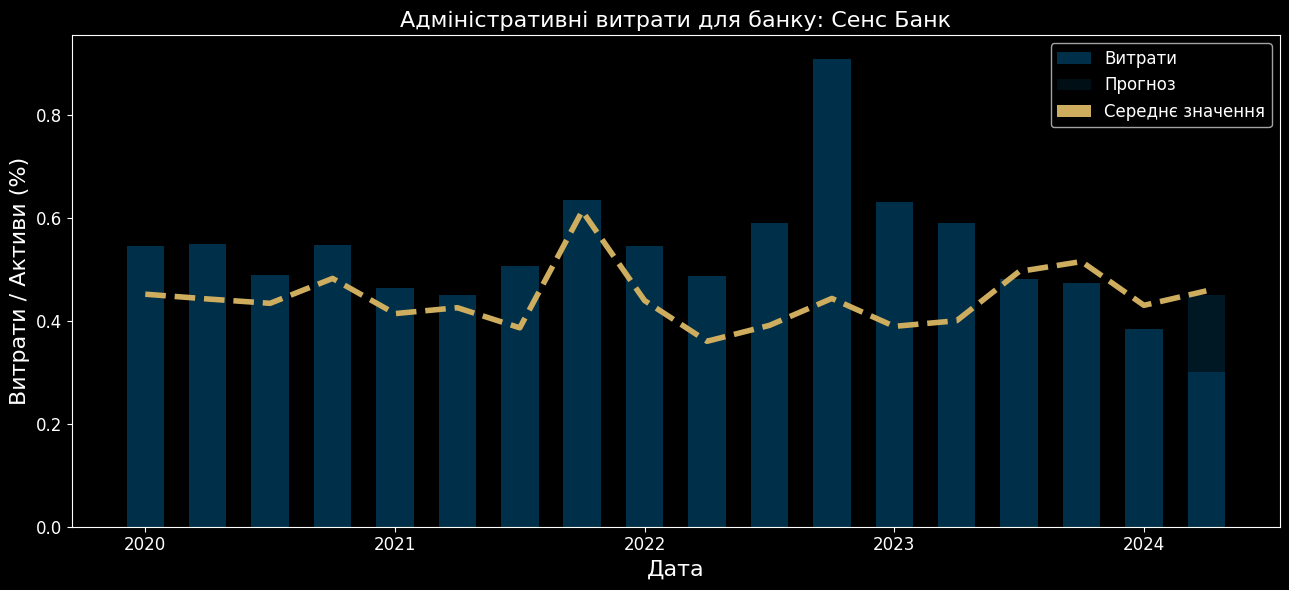

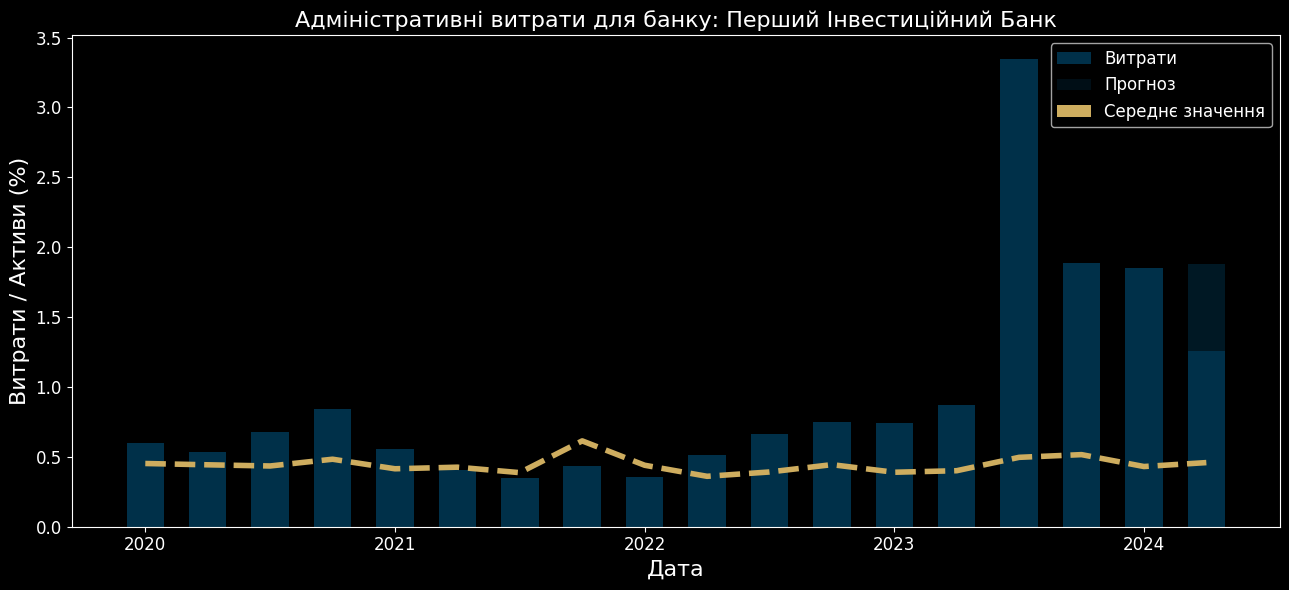

In [5]:
# Load the data
df_expenses_state = pd.read_csv('data/quarterly/administrative_expenses.csv', index_col=0)
df_expenses_private = pd.read_csv('data/quarterly/private_administrative_expenses.csv', index_col=0)

df_assets_state = pd.read_csv('data/quarterly/total_assets.csv', index_col=0)
df_assets_private = pd.read_csv('data/quarterly/private_total_assets.csv', index_col=0)

df_expenses_assets_state = (df_expenses_state / df_assets_state) * 100
df_expenses_assets_private = (df_expenses_private / df_assets_private) * 100

df_combined = pd.concat([df_expenses_assets_state, df_expenses_assets_private], axis=1)
df_combined.reset_index(inplace=True)
df_combined['year_month'] = df_combined['date'].apply(lambda x: x[:7])

banks_ua = ["ПриватБанк", "Ощадбанк", "Укрексім", "Укргазбанк", "Сенс Банк", "Перший Інвестиційний Банк"]

# Calculate the average of each row
df_combined['average'] = df_combined.mean(axis=1)

banks = df_expenses_assets_state.columns

# Plotting histograms for each bank
# Plotting histograms for each bank
for index, bank in enumerate(banks):
    expenses = df_expenses_assets_state[bank].values
    average = df_combined['average'].values
    months = df_combined['year_month'].values

    plt.figure(figsize=(13, 6))

    # Plot all bars except the last one
    plt.bar(months[:-1], expenses[:-1], width=0.6, label='Витрати', align='center', color='#003049')

    # Plot the last bar in two parts
    last_bar_height = expenses[-1]
    opaque_height = last_bar_height * 2/3  # Bottom 2/3
    transparent_height = last_bar_height / 3  # Top 1/3

    # Plot the opaque part (bottom 2/3)
    plt.bar(months[-1], opaque_height, width=0.6, align='center', color='#003049')

    # Plot the transparent part (top 1/3)
    plt.bar(months[-1], transparent_height, bottom=opaque_height, width=0.6, align='center', color='#003049', alpha=0.5, label='Прогноз')

    # Plot the average line
    plt.plot(months, average, color='#cead5f', label='Середнє значення', linestyle='--', linewidth=4)

    plt.xlabel('Дата', fontsize = 16)
    plt.ylabel('Витрати / Активи (%)', fontsize = 16)
    plt.title(f'Адміністративні витрати для банку: {banks_ua[index]}', fontsize = 16)

    # Customize x-axis ticks to show every half year
    short_months = [month[:4] for month in months]
    plt.xticks(np.arange(len(short_months))[::4], short_months[::4], fontsize=12)
    plt.yticks(fontsize = 12)
    plt.style.use('dark_background')

    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#003049', label='Витрати'),
        Patch(facecolor='#003049', alpha=0.3, label='Прогноз'),
        Patch(facecolor='#cead5f', label='Середнє значення')
    ]
    plt.legend(handles=legend_elements, fontsize = 12)

    plt.tight_layout()
    plt.show()

Index(['date', 'Державні', 'Приватні', 'Приватбанк'], dtype='object')


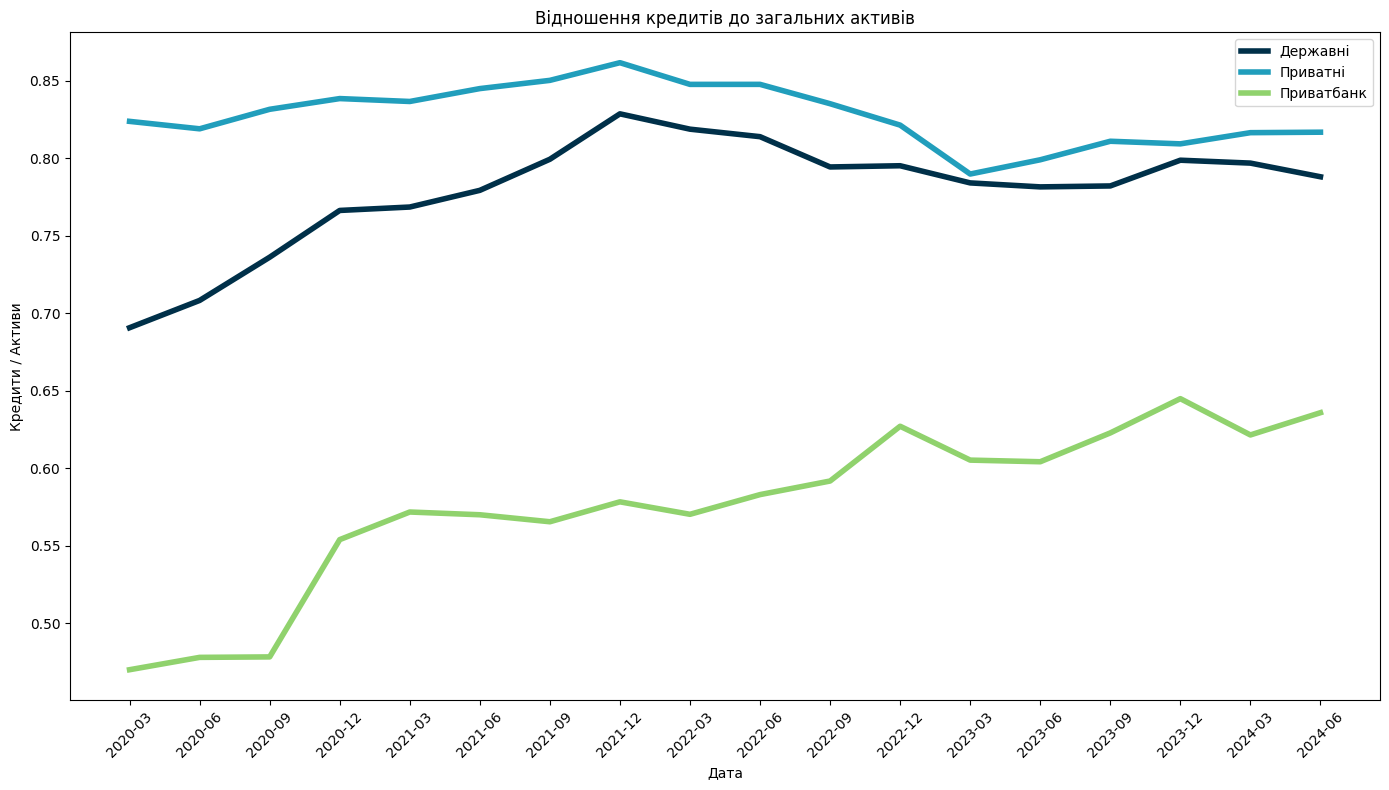

In [10]:
def private_state(private_file, state_file):
    df_state = pd.read_csv(state_file, index_col=0)
    df_private = pd.read_csv(private_file, index_col=0)

    numeric_cols = df_state.select_dtypes(include=np.number).columns.tolist()
    if "privatbank" in df_state.columns:
        df_state['average_state'] = (df_state[numeric_cols].sum(axis=1) - df_state['privatbank']) / 5
    else:
        df_state['average_state'] = (df_state[numeric_cols].sum(axis=1) - df_state['приватбанк']) / 5

    numeric_cols_2 = df_private.select_dtypes(include=np.number).columns.tolist()
    df_private['average_private'] = df_private[numeric_cols_2].sum(axis=1) / 13

    if "privatbank" in df_state.columns:
        df_state_private = pd.DataFrame({
        'Державні': df_state['average_state'],
        'Приватні': df_private['average_private'],
        'Приватбанк': df_state['privatbank']
        })
    else:
        df_state_private = pd.DataFrame({
        'Державні': df_state['average_state'],
        'Приватні': df_private['average_private'],
        'Приватбанк': df_state['приватбанк']
        })
    return df_state_private


df_due = private_state('data/quarterly/private_due_from_other_banks.csv', 'data/quarterly/due_from_other_banks.csv')
df_receivables = private_state('data/quarterly/private_receivables_from_customers.csv', 'data/quarterly/receivables_from_customers.csv')
df_financial_assets = private_state('data/quarterly/private_financial_assets.csv', 'data/quarterly/financial_assets.csv')
df_securities1 = private_state('data/quarterly/private_securities1.csv', 'data/quarterly/securities1.csv')
df_securities2 = private_state('data/quarterly/private_securities2.csv', 'data/quarterly/securities2.csv')


df_loans = df_due + df_receivables + df_financial_assets + df_securities1 + df_securities2

df_total_assets = private_state('data/quarterly/private_total_assets.csv', 'data/quarterly/total_assets.csv')

df_loans_assets = (df_loans / df_total_assets)
df_loans_assets.to_csv('new2.csv')


# Assuming df_loans_assets is already defined and has 'date' as the index
# Reset index to make 'date' a column
df_loans_assets.reset_index(inplace=True)
print(df_loans_assets.columns)

# Extract 'year_month' from 'date'
df_loans_assets['year_month'] = df_loans_assets['date'].apply(lambda x: x[:7])



# Plotting
plt.figure(figsize=(14, 8))

# Colors for the plot
colors = {
    'Державні': '#003049',
    'Приватбанк': '#90D26D',    
    'Приватні': '#219EBC'
}

for bank in df_loans_assets.columns:
    if (bank != 'year_month' and bank != 'date'):
        plt.plot(df_loans_assets['year_month'], df_loans_assets[bank], label=bank.capitalize(), color=colors[bank], linewidth = 4)

plt.title('Відношення кредитів до загальних активів')
plt.xlabel('Дата')
plt.ylabel('Кредити / Активи')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


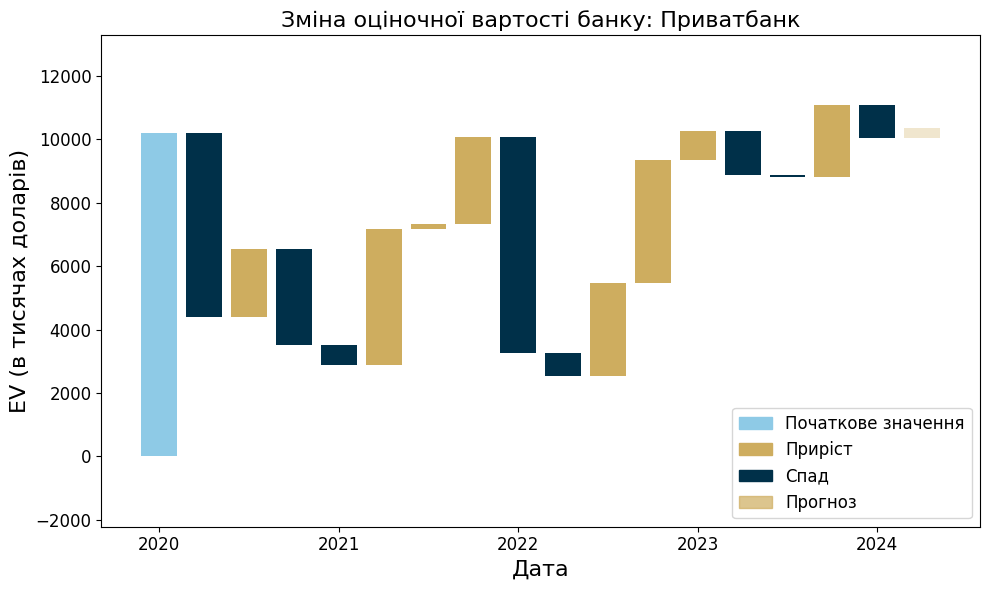

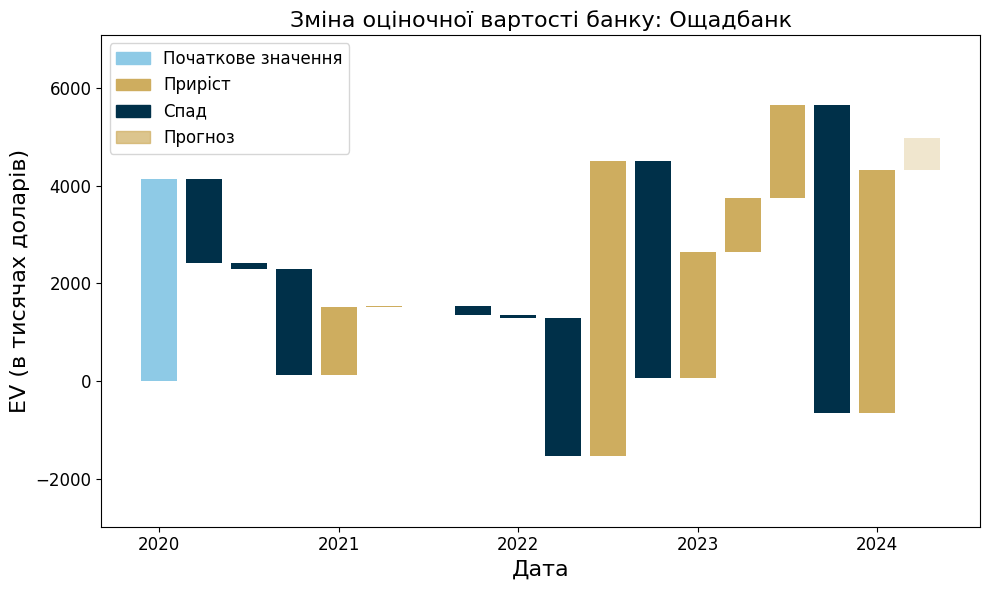

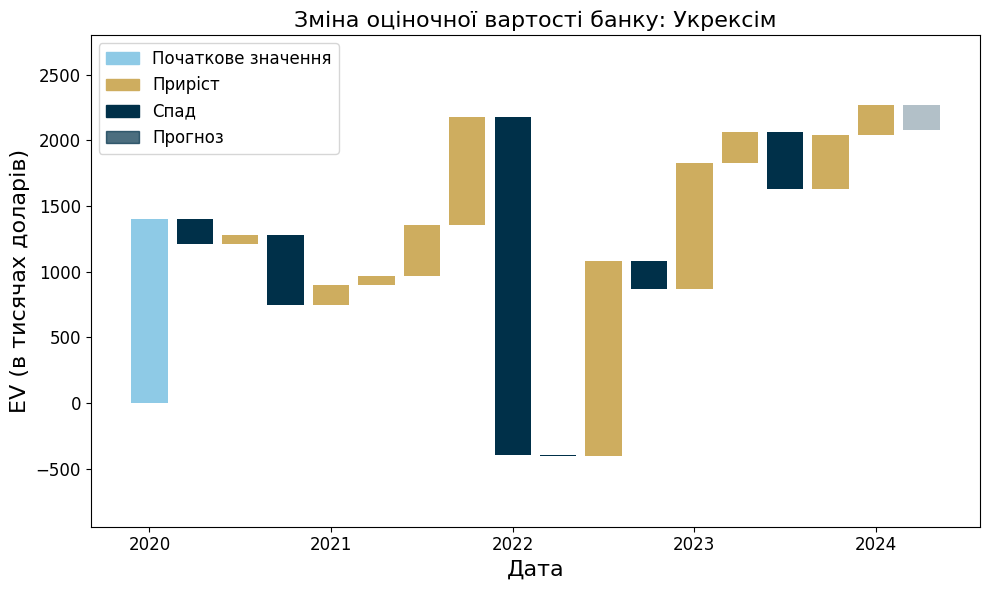

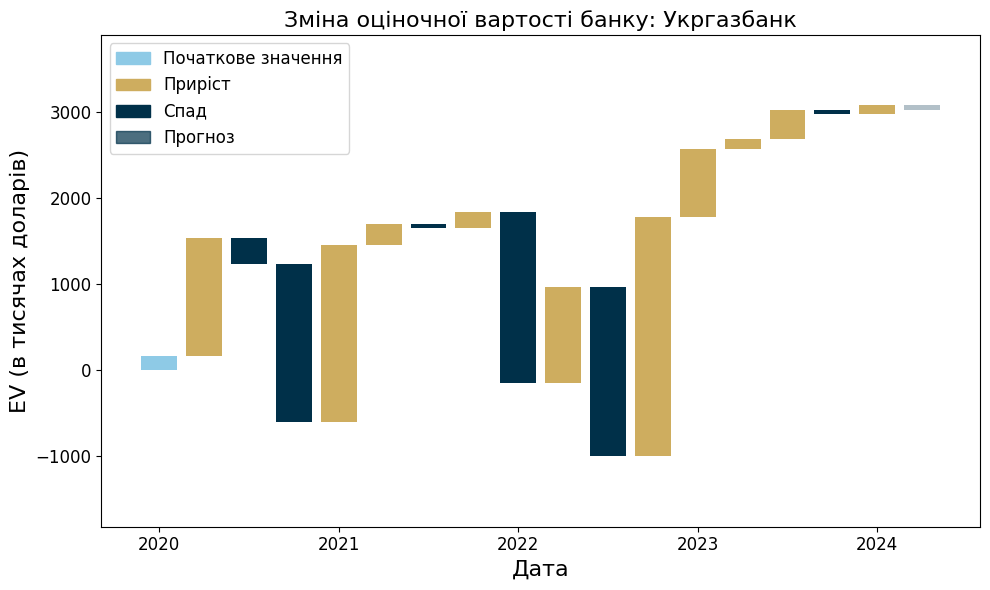

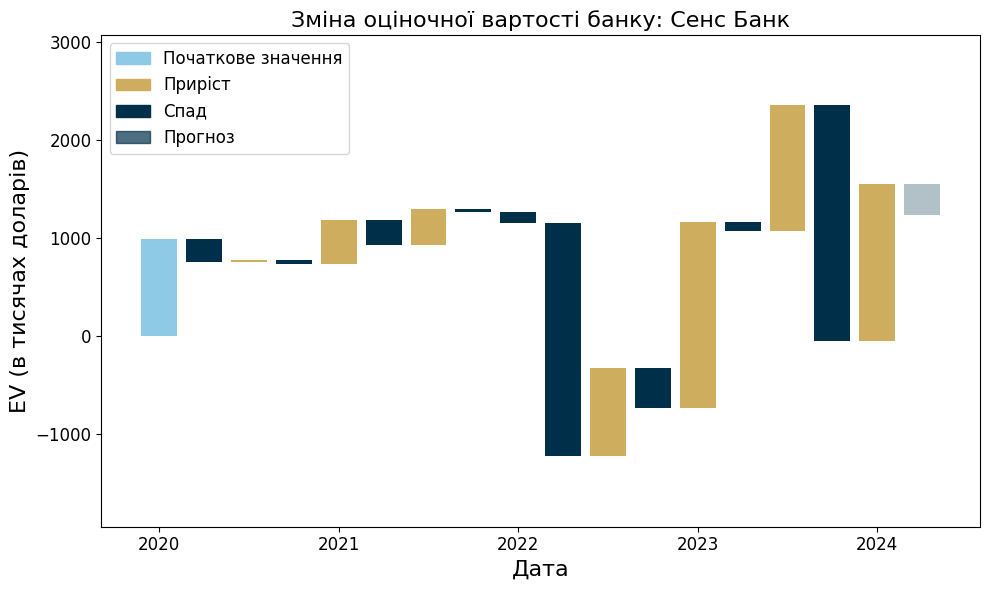

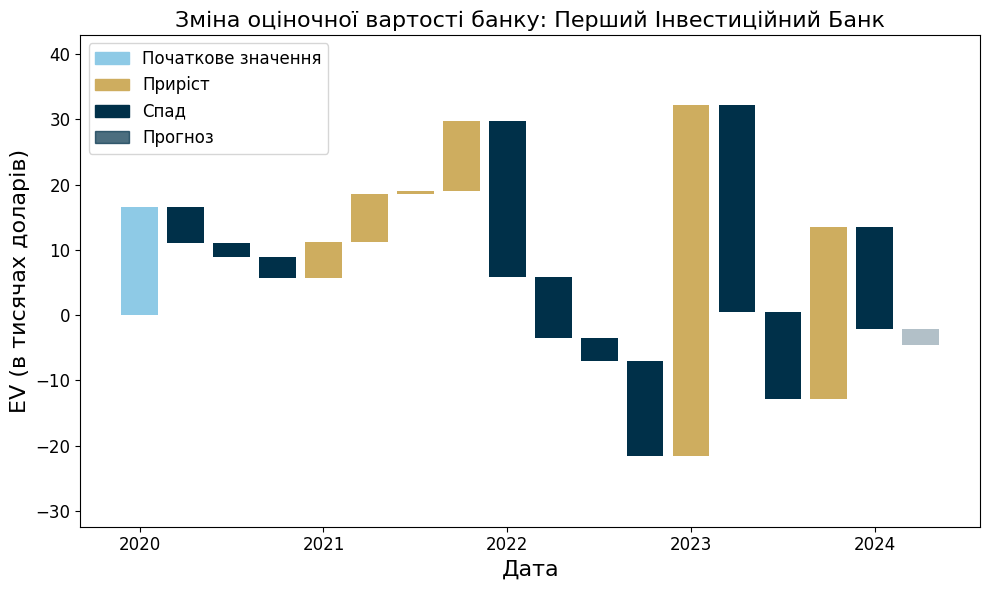

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load data
banks_ua = ["Приватбанк", "Ощадбанк", "Укрексім", "Укргазбанк", "Сенс Банк", "Перший Інвестиційний Банк"]
df_profit_before_tax = pd.read_csv('data/dollarized_quaterly/new_profit_before_tax.csv', index_col=0)
df_interest_expenses = pd.read_csv('data/dollarized_quaterly/new_interest_expenses.csv', index_col=0)
df_ebit = ((df_profit_before_tax + df_interest_expenses) * 17.98) / 1000

# Calculate EBIT difference
df_ebit_diff = df_ebit.diff().fillna(df_ebit)

# List of banks
banks = df_ebit.columns.tolist()

# Function to create waterfall chart
def plot_waterfall(data, labels, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    # Adjust margins
    plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.2)
    
    # Starting point
    x = labels
    y = data
    
    cumulative = 0
    for i in range(len(y)):
        if i == 0:
            plt.bar(x[i], y[i], color='#8ECAE6', label='Початкове значення')
        elif i == len(y) - 1:  # Last bar
            plt.bar(x[i], y[i], bottom=cumulative, color='#cead5f' if y[i] > 0 else '#003049', 
                    label='Приріст' if y[i] > 0 else 'Спад', alpha=0.3)  # Make it transparent
        else:
            plt.bar(x[i], y[i], bottom=cumulative, color='#cead5f' if y[i] > 0 else '#003049', 
                    label='Приріст' if y[i] > 0 else 'Спад')
        cumulative += y[i]
    
    # Create custom legend
    handles = [
        Patch(color='#8ECAE6', label='Початкове значення'),
        Patch(color='#cead5f', label='Приріст'),
        Patch(color='#003049', label='Спад'),
        Patch(color='#cead5f' if y[-1] > 0 else '#003049', alpha=0.7, label='Прогноз')
    ]
    
    plt.title(title, fontsize = 16)
    plt.xlabel('Дата', fontsize = 16)
    plt.ylabel('EV (в тисячах доларів)', fontsize = 16)
    short_labels = [label[:4] for label in x]
    plt.xticks(np.arange(len(short_labels))[::4], short_labels[::4], fontsize=12)
    plt.yticks(fontsize = 12)
    
    y_min, y_max = ax.get_ylim()
    y_range = y_max - y_min
    ax.set_ylim(y_min - 0.2 * y_range, y_max + 0.2 * y_range)
    
    plt.legend(handles=handles, fontsize = 12)
    plt.tight_layout()
    plt.show()

# Create waterfall charts for each bank
for index, bank in enumerate(banks):
    data = df_ebit_diff[bank].tolist()
    labels = [label[:7] for label in df_ebit_diff.index.tolist()]  # Take only the first 7 characters of each label
    plot_waterfall(data, labels, f'Зміна оціночної вартості банку: {banks_ua[index]}')


Index(['privatbank', 'oschadbank', 'ukreximbank', 'ukrgasbank', 'sense',
       'first investment bank', 'Total'],
      dtype='object')
date
2020-03-31    1.688161e+09
2020-06-30    1.747795e+09
2020-09-30    1.777250e+09
2020-12-31    1.695173e+09
2021-03-31    1.676244e+09
2021-06-30    1.656935e+09
2021-09-30    1.646841e+09
2021-12-31    1.694488e+09
2022-03-31    1.718863e+09
2022-06-30    1.855990e+09
2022-09-30    2.089408e+09
2022-12-31    2.153642e+09
2023-03-31    2.220031e+09
2023-06-30    2.263688e+09
2023-09-30    2.358658e+09
2023-12-31    2.516974e+09
2024-03-31    2.578743e+09
2024-06-30    1.729407e+09
Name: privatbank, dtype: float64
date
2020-03-31    9.623327e+08
2020-06-30    8.933492e+08
2020-09-30    8.137837e+08
2020-12-31    8.090668e+08
2021-03-31    8.467692e+08
2021-06-30    8.579784e+08
2021-09-30    7.745954e+08
2021-12-31    7.304797e+08
2022-03-31    7.400806e+08
2022-06-30    7.670216e+08
2022-09-30    7.969070e+08
2022-12-31    8.517931e+08
2023-03-31

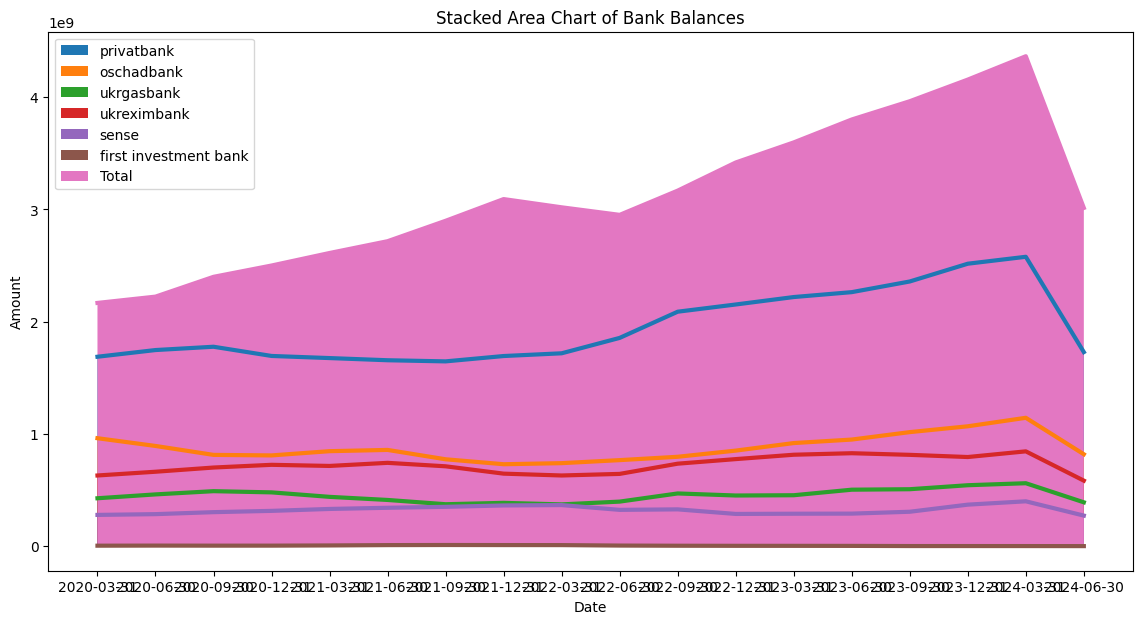

In [6]:
df_assets_state = pd.read_csv('data/quarterly/total_assets.csv', index_col=0)
df_assets_private = pd.read_csv('data/quarterly/total_assets_all.csv', index_col=0)
df_combined = pd.concat([df_assets_state, df_assets_private], axis=1)

banks = ["privatbank", "oschadbank", "ukrgasbank", "ukreximbank", "sense", "first investment bank", 'Total']
print(df_combined.columns)



    # Plotting
plt.figure(figsize=(14, 7))

    # Plot the stacked area with transparency
for bank in banks:
    print(df_combined[bank])
    plt.fill_between(df_combined.index, df_combined[bank], label=bank)
    plt.plot(df_combined.index, df_combined[bank], linewidth=3)

    # Add labels and title
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Stacked Area Chart of Bank Balances')
plt.legend()

    # Show plot
plt.show()
df_combined.to_csv('new2.csv')